# Introduction

Marketing companies often launch campaigns with the expectation of success, but due to the complexities of the market and the various possible approaches, results can be uncertain. To address this, they commonly utilize A/B tests, a randomized experimentation process. This involves presenting two or more versions of a variable to different segments of the audience simultaneously. The goal is to identify which version generates the most significant impact and drives essential business metrics.

The purpose of the dataset is to analyze these groups and determine the success of the advertisements, the potential revenue the company can generate from the ads, and whether there is a statistically significant difference between the groups. This analysis aims to provide valuable insights into the effectiveness of the marketing strategies and the potential outcomes for the company's advertising efforts.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.stats.proportion as ssp
import statsmodels.stats.power as smp
from statsmodels.stats.power import GofChisquarePower
import math
from scipy.stats import chi2_contingency

In [2]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# Provide the link to share the file/folder located on Google Drive.
link ='https://drive.google.com/file/d/1ous-K5goRfoA2hzWLTRI6FPuYhV_jhI9/view?usp=sharing'
# Extract the ID of the file
id = link.split("/")[-2]
# Create and load the dataset
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('marketing_AB.csv')

The data used for this project is intended for conducting an A/B testing. It consists of 588,101 rows distributed across 7 columns. To start, we analyze the first five rows of the dataset to familiarize ourselves with its contents.

In [4]:
# Load original dataset as dataframe
df = pd.read_csv('marketing_AB.csv',index_col=0)
display(df.head())

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In doing this project, we would like to know several things, which are listed below.


1.   Exploratory data analysis
2.   What is the conversion rate for the control and treatment variables?
3.   Determine the minimum sample size needed for both control and treatment variables
4.   Would employing ads make a difference at upselling the product? Are the differences statistically significant?



## 1. Exploratory data analysis

Initially, we conduct exploratory data analysis (EDA) to gain a better understanding of the dataset's characteristics. EDA serves the purpose of observing initial trends and patterns within the data. This involves plotting figures and graphs that provide valuable insights into the information. Furthermore, EDA aids in assessing data quality, examining data distribution, and identifying the presence of any outliers or missing values. Through this process, we can uncover important aspects of the data that will guide further analysis and decision-making.

We use `df.info()` to get a summary of a DataFrame.

In [5]:
df.info

<bound method DataFrame.info of         user id test group  converted  total ads most ads day  most ads hour
0       1069124         ad      False        130       Monday             20
1       1119715         ad      False         93      Tuesday             22
2       1144181         ad      False         21      Tuesday             18
3       1435133         ad      False        355      Tuesday             10
4       1015700         ad      False        276       Friday             14
...         ...        ...        ...        ...          ...            ...
588096  1278437         ad      False          1      Tuesday             23
588097  1327975         ad      False          1      Tuesday             23
588098  1038442         ad      False          3      Tuesday             23
588099  1496395         ad      False          1      Tuesday             23
588100  1237779         ad      False          1      Tuesday             23

[588101 rows x 6 columns]>

###Description of the dataset column

In this phase, we provide a comprehensive description of the column definitions to understand the variables in the dataset accurately. This foundational understanding is crucial for making informed decisions and drawing meaningful conclusions from the data.

*   `Index`: Row index
*   `user id`: User ID (unique)
*   `test group`: If "ad" the person saw the advertisement, if "psa" they only saw the public service announcement
*   `converted`: If a person bought the product then True, else is False
*   `total ads`: Amount of ads seen by person
*   `most ads day`: Day that the person saw the biggest amount of ads
*   `most ads hour`: Hour of day that the person saw the biggest amount of ads

After obtaining a clear understanding of the column definitions, the next step is to drop duplicates from the dataset to ensure that all rows are distinct and unique. This process helps maintain data integrity and prevents redundant information from affecting the analysis.

In [6]:
df.drop_duplicates(inplace=True)

Following the removal of duplicates, the subsequent step involves checking the data types to ensure that each data field is assigned to the correct type. Verifying the appropriate data types is essential for accurate computations and analyses, preventing potential errors arising from incorrect data formats.

In [7]:
df.dtypes

user id           int64
test group       object
converted          bool
total ads         int64
most ads day     object
most ads hour     int64
dtype: object

We have observed that the `most ads day` column is currently in the object data type, which should ideally be represented as a categorical data type, we can use the `pd.Categorical` function to convert it accordingly. By doing this conversion, we ensure that the `most ads day` data is represented in the appropriate categorical format, which can be more efficient for certain operations and analyses.

In [8]:
cat = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['most ads day'] = pd.Categorical(df['most ads day'], categories=cat, ordered=True)

Verifying whether the format has been changed

In [9]:
df['most ads day'].dtype

CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                  'Saturday', 'Sunday'],
, ordered=True)

##2. What is the conversion rate for the control and treatment variables?

Controlled variables in an experiment are the ones that researchers intentionally hold constant or control. These variables are elements that researchers strive to keep consistent throughout their study to ensure they do not influence the outcomes. Hence, in other words, the controlled variables are features that remain unchanged throughout the experiment.

Thus, within this dataset, the control group consists of individuals who were exposed to ads, whereas those who did not see the ads are referred to as the treatment group.

[Conversion rate](https://chartio.com/learn/product-analytics/what-is-conversion-rate/) represents the average number of conversions per ad interaction, presented as a percentage. It is determined by dividing the total number of conversions by the number of ad interactions that can be attributed to a conversion within the same time period.

$ Conversion Rate = \dfrac{Total Conversions}{Total Interactions} $

As an example, suppose there were 100 individuals in the control group, and within this group, 40 people purchased the product. To calculate the conversion rate, we divide the number of conversions (40) by the total number of people in the control group (100):

Conversion Rate = Number of Conversions / Total Number in Control Group

Conversion Rate = 40 / 100

Conversion Rate = 0.4

Therefore, the conversion rate for the control group is 0.4 or 40%. This indicates that 40% of the individuals in the control group made a purchase.


In [10]:
# Number of conversions for control and treatment
control_conversions = len(df[(df['test group']=='psa') & (df['converted']== True)])
treatment_conversions = len(df[(df['test group']=='ad') & (df['converted']== True)])

# Total number of observations for control and treatment
control_total = len(df[df['test group']=='psa'])
treatment_total = len(df[df['test group']=='ad'])

# Calculating conversion rates
control_conversion_rate = control_conversions / control_total
treatment_conversion_rate = treatment_conversions / treatment_total

# Printing the conversion rates
print("Control Conversion Rate:", control_conversion_rate)
print("Treatment Conversion Rate:", treatment_conversion_rate)

Control Conversion Rate: 0.01785410644448223
Treatment Conversion Rate: 0.025546559636683747


Alternatively, we can simplify the process by employing the `groupby` method to compute the conversion rate.

In [11]:
conversion_rate = df.groupby('test group')['converted'].mean()
print(conversion_rate)

test group
ad     0.025547
psa    0.017854
Name: converted, dtype: float64


The results obtained from both approaches appear to be identical.

Following that, we want to generate a bar chart representing the conversion rate for each day. To accomplish this, the initial step involves calculating the conversion rate for each day and organizing this data into a dataframe.

In [12]:
# Calculate conversion rate by day and test group
conversion_by_day = df.groupby(["most ads day", "test group"])["converted"].mean()
conversion_by_day

most ads day  test group
Monday        ad            0.033241
              psa           0.022559
Tuesday       ad            0.030440
              psa           0.014448
Wednesday     ad            0.025356
              psa           0.015759
Thursday      ad            0.021637
              psa           0.020230
Friday        ad            0.022465
              psa           0.016303
Saturday      ad            0.021307
              psa           0.013996
Sunday        ad            0.024620
              psa           0.020595
Name: converted, dtype: float64

To construct a stacked bar chart, it is necessary to ensure that all the data is at the same level, where the day serves as the index, and `ad` and `psa` are represented as columns. In this context, we utilize the `unstack` function to achieve the desired data arrangement.

The `unstack` method offers the option to include an additional parameter called "level," which determines the hierarchical index level to be unstacked.
In a DataFrame with multiple index levels (a multi-index DataFrame), you can choose which level to use for creating new columns. The levels are zero-indexed, meaning that level=0 corresponds to the first level, level=1 represents the second level, and so on.


By applying the `unstack` method with `level=1` on the DataFrame, new columns 'I' and 'II' are created. This parameter allows you to specify the particular index level to pivot and transform into columns.

In [13]:
# Reshape the data from long to wide format
conversion_by_day = conversion_by_day.unstack(level=1)

# Print the result
print(conversion_by_day)

test group          ad       psa
most ads day                    
Monday        0.033241  0.022559
Tuesday       0.030440  0.014448
Wednesday     0.025356  0.015759
Thursday      0.021637  0.020230
Friday        0.022465  0.016303
Saturday      0.021307  0.013996
Sunday        0.024620  0.020595


As you can see, the DataFrame is "unstacked" using the values from Index Level 1 to create new columns 'I' and 'II'. The corresponding values are placed in their respective rows under these new columns.

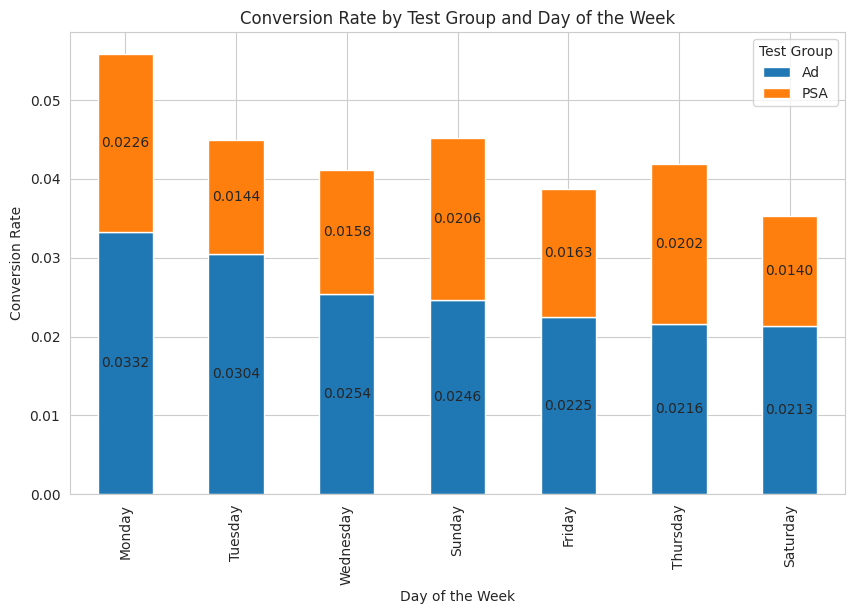

In [14]:
# Sort the values in descending order
conversion_by_day = conversion_by_day.sort_values(by=["ad", "psa"], ascending=False)

# Create a stacked bar plot of the conversion rate by day and test group
sns.set_style("whitegrid")
ax = conversion_by_day.plot(kind="bar", stacked=True, figsize=(10, 6))
plt.title("Conversion Rate by Test Group and Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Conversion Rate")

# Add value labels to each bar segment
for i in range(conversion_by_day.shape[0]):
    ad_value = conversion_by_day.iloc[i]["ad"]
    psa_value = conversion_by_day.iloc[i]["psa"]
    ax.text(i, ad_value / 2, f"{ad_value:.4f}", ha="center", va="center")
    ax.text(i, ad_value + psa_value / 2, f"{psa_value:.4f}", ha="center", va="center")

plt.legend(title="Test Group", labels=["Ad", "PSA"])
plt.show()

In [15]:
0.1+0.2

0.30000000000000004

From the figure, it is evident that for both categories, `ad` and `psa`, Monday exhibits the highest conversion rate, indicating the day with the most significant number of successful actions or purchases. On the other hand, Saturday displays the lowest conversion rate for both categories, suggesting it is the day with the fewest successful actions or purchases.

##3. Determine the minimum sample size needed for both control and treatment variables.

[Power analysis](https://www.tibco.com/reference-center/what-is-power-analysis#:~:text=A%20power%20analysis%20is%20the,it%20is%20genuine%20and%20significant.) is the calculation used to determine the smallest sample size necessary for an experiment, considering the required significance level, statistical power, and effect size.

In marketing, one method for analyzing the results of A/B testing is by employing the chi-square test. The chi-square test is a statistical analysis that compares the observed frequencies of categorical data to the expected frequencies, based on a specific hypothesis. Moreover, the chi-square test is commonly used to compare the distribution of categorical data, allowing researchers to assess whether there is a significant difference between the observed and expected distributions.

There are two primary types of chi-square tests are commonly utilized: the Test for Independence and the Test for Homogeneity. The Test for Homogeneity serves the purpose of comparing the distribution of one categorical variable across various groups of another categorical variable. On the other hand, the Test for Independence aims to establish whether there is a statistically significant association between two categorical variables.

In the context of A/B testing, we employ the chi-square test for independence to determine the statistical significance of the observed differences in proportions or frequencies between groups. This test helps discern whether these differences could have arisen by random chance or if there is a meaningful association between the variables "exposure to different conditions" (representing the experimental groups) and "outcome" (such as conversion).


For conducting a power analysis using the chi square testing method, the appropriate module to utilize is `GofChisquarePower`. The GofChisquarePower function is part of the statsmodels library, which is not included in Python's standard library. As a result, readers need to install the statsmodels library separately before utilizing the GofChisquarePower function.This function is specifically designed to perform power analysis related to the chi-square goodness-of-fit test.

Prior to conducting a power analysis, it is essential to establish the effect size for a test that compares two proportions.

In [16]:
# Calculate the effect size
effect_size = ssp.proportion_effectsize(control_conversion_rate, treatment_conversion_rate)

# Print the effect size
print("Effect Size:", effect_size)

Effect Size: -0.053002578606030915


In [17]:
# Perform power analysis
analysis = GofChisquarePower()
sample_size = analysis.solve_power(effect_size=effect_size, alpha=0.05, power=0.8)*2 ##times 2 because it's a one way test without it

# Print the estimated minimum sample size
print("Estimated Minimum Sample Size:", round(float(sample_size)))

Estimated Minimum Sample Size: 5588


Even though we have already obtained the sample mean using the `gofchisquarepower` method, we perform a manual sample size calculation using the z-score to verify the results,. This re-check helps ensure the accuracy of our findings.

We have developed a function named `sample_size_calculator` that helps in determining the necessary sample size for estimating a population parameter with a specific level of confidence and a given margin of error. Within the function, we perform calculations to determine the sample size based on a [finite population](https://www.researchgate.net/publication/45459002_Pratical_Issues_in_Calculating_the_Sample_Size_for_Prevalence_Studies) and known in advance.

The formula utilized in the function is as follows:


$ n= \frac{N * (Z^2) * (P * (1-P))}{(d^2 * (N - 1)) + Z^2 * P * (1-P)} $


This formula proves useful when you possess prior information about the population size and aim to compute the required sample size for estimating a population proportion. Taking the population size into account allows for adjustments to the sample size accordingly. The inclusion of the finite population correction factor becomes particularly significant when the population is relatively small, and the sample size represents a substantial portion of the entire population.

We aim for a confidence level of 99%, which corresponds to a Z-score of 2.576 in a standard normal distribution. With this Z-score, approximately 99% of the data falls within 2.576 standard deviations from the mean.


Here is an overview of our decisions regarding the calculation of the sample size:

* `Z = 2.576`: This value is used for the Z-score to achieve the desired 99% confidence level, ensuring that most of the data is within the specified range.

* `d = 0.01`: Here, d represents the margin of error, which is the difference between the sample estimate and the true population parameter. We set it to 0.01 to have a 1% margin of error.

* `P = 0.5`: In cases where the population proportion (P) is unknown, we assume P to be 0.5 (50%). This assumption provides a conservative estimate for the sample size, making the study more robust.

By incorporating these parameters, we can calculate the appropriate sample size for the study with a 99% confidence level, a 1% margin of error, and an unknown population proportion.

In [18]:
def sample_size_calculator(N, Z = 2.576, P = 0.5, d = 0.01):
    # math.ceil is to round up
    return math.ceil((N * (Z**2) * (P * (1-P))) / ((d**2 * (N - 1)) + Z**2 * P * (1-P)))

Subsequently, we input the data into the function.

In [19]:
sample_size = sample_size_calculator(N=df.shape[0])
print(f"The required sample size is: {sample_size}")

The required sample size is: 16135


The outcome varies depending on the sample size calculation method employed. The "gofchisquarepower" method yields a sample size of 5588, whereas using the equation proposed by [Naing et al.](https://www.researchgate.net/publication/45459002_Pratical_Issues_in_Calculating_the_Sample_Size_for_Prevalence_Studies) results in a sample size of 384. To account for this difference, both sample sizes will be retained, and subsequently, an A/B test will be conducted for each sample to determine if there are any discrepancies in the results.

##4. Would employing ads make a difference at upselling the product?
Does the implementation of ads result in a notable increase in product upselling? Is this difference statistically significant or merely due to chance? Our Null Hypothesis (H0) states that showing ads does not have a significant impact on the number of purchases. Conversely, the Alternative Hypothesis (H1) suggests that displaying ads does have a significant effect on the number of purchases.

To investigate whether employing ads would have an impact on upselling the product, we will employ A/B testing. Specifically, we will use the chi-square test to analyze the data and draw conclusions regarding the potential difference in product upselling with the inclusion of ads. This statistical approach allows us to compare the outcomes of two groups, one with ads and the other without, and determine if there is a significant association between the ads and the product upselling performance.

Initially, we parse the data based on the specified sample size for each test. In this scenario, we utilize the first sample size, which is 5588 items, as determined earlier. The data is then organized in a manner where each `test group` contains a sample size of 5588, ensuring that the groups have equal numbers of observations. This process is crucial for conducting valid A/B tests, as it allows for a fair and balanced comparison between the different experimental conditions.

We also specify random_state = 1 to ensure that the data split remains consistent across different runs.

In [20]:
df_5588 =  df.groupby("test group").sample(n=5588, random_state=1)
df_5588['test group'].value_counts()

ad     5588
psa    5588
Name: test group, dtype: int64

After gathering the necessary data, the next step is to use the pd.crosstab function to summarize and analyze the relationship between the `test group` and `converted` variables in the DataFrame. This function creates a contingency table that allows us to examine the frequency distribution of the two categorical variables and their association.

In [21]:
Xtab = pd.crosstab(df_5588['test group'], df_5588['converted'])

print(Xtab)

converted   False  True 
test group              
ad           5437    151
psa          5478    110


Once we have created the contingency table `Xtab`, our next step is to conduct a chi-square test using the data from the table. This statistical test will help us evaluate the significance of any relationship between the `test group` and `converted` variables.

The chi-square test yields a p-value, which indicates the likelihood of observing the data's association between the variables if they were independent or no meaningful relationship. A low p-value indicates a strong association, while a high p-value suggests that any association is likely due to chance.

We will use an alpha value of 0.05 as a threshold to determine whether to reject or accept the null hypothesis based on the p-value. This will allow us to determine if there is a statistically significant connection between the `test group` (with or without ads) and the `converted` variable (upselling of the product). If the p-value is less than 0.05 indicated that employing ads has a substantial impact on upselling the product.

In [22]:
# Calculate the p-value
chi2, pval, dof, expected = chi2_contingency(Xtab)

# Print the p-value
print("The t-test p-value is {:.4f}".format(pval))

if pval < 0.05:
    print ( 'Reject the null hypothesis. There is a significant difference between the two groups.')
else:
    print ('Fail to reject the null hypothesis. There is no significant difference between the two groups.')

The t-test p-value is 0.0122
Reject the null hypothesis. There is a significant difference between the two groups.


Based on the obtained results from the test with a sample size of 5588, we observe a p-value of 0.0122, which is less than the significance level of 0.05. Consequently, we reject the null hypothesis (H0), which suggests that showing ads has no significant impact on the number of purchases. Instead, the data indicates that there is indeed a significant impact on the number of purchases with the existence of ads. In other words, employing ads has a notable effect on upselling the product.

Next, we will conduct the same test with the same hypothesis, but this time using the second sample size of 16135. To ensure consistency across different runs, we will set the random_state parameter to 1. This allows us to control the randomness in the test, ensuring that the results remain consistent and reproducible across multiple executions.

After performing the test with a sample size of 16135, we will again analyze the p-value to determine the statistical significance of the impact of ads on the number of purchases. This will enable us to compare the results between the two sample sizes and draw meaningful conclusions about the effect of employing ads on upselling the product with a larger sample size.

As previously, we will parse the data based on the specified sample size for each test, which, in this case, is 16135.

In [23]:
df_16135 =  df.groupby("test group").sample(n=16135, random_state=1)
df_16135['test group'].value_counts()

ad     16135
psa    16135
Name: test group, dtype: int64

As part of the analysis for the second test with a sample size of 16135, we will again utilize the pd.crosstab function. This function enables us to summarize and analyze the relationship between the `test group` and `converted` variables within the DataFrame.

In [24]:
Xtab = pd.crosstab(df_16135['test group'], df_16135['converted'])

Following the acquisition of the contingency table, our subsequent action involves performing a chi-square test using the data from the table. This step is to determine whether utilizing a sample size of 16135 will yield results that either reject the null hypothesis or fail to reject it, similar to the previous test.

In [25]:
# Calculate the p-value
chi2, pval, dof, expected = chi2_contingency(Xtab)

# Print the p-value
print("The t-test p-value is {:.4f}".format(pval))

if pval < 0.05:
    print ( 'Reject the null hypothesis. There is a significant difference between the two groups.')
else:
    print ('Fail to reject the null hypothesis. There is no significant difference between the two groups.')

The t-test p-value is 0.0000
Reject the null hypothesis. There is a significant difference between the two groups.


From the results obtained in the test with a sample size of 16,135, we can observe a p-value of 0.0000, which is smaller than the significance level of 0.05. As a result, we reject the null hypothesis (H0), which posits that showing ads has no significant impact on the number of purchases. Instead, the data suggests a substantial effect on the number of purchases when ads are present. In other words, employing ads significantly influences upselling the product, as supported by the statistical analysis.

After conducting A/B tests using sample sizes obtained from both the `GofChisquarePower` function and our manual calculations, we arrive at consistent outcomes. In both cases, we reject the null hypothesis (H0), which indicates that showing ads does have a significant impact on the number of purchases.

This indicates that employing ads does result in a significant difference in the number of purchases. In other words, the presence of ads does make a noteworthy difference in the product upselling process , as evidenced by the statistical analysis conducted in the A/B tests.

# Acknowledgements and Recommendations
The dataset was uploaded to [Kaggle](https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing?datasetId=1660669&sortBy=voteCount)
 by the user [FAVIOVÁZQUEZ](https://www.kaggle.com/faviovaz) around August 2022.

For future analysis, I suggest conducting a thorough exploration of how ads influence consumer behavior and finding the optimal ad exposure level that drives product purchases. To achieve this, consider performing A/B Testing with Different Ad Exposure Level.

---


# Data License
This data is licensed under [Creative Commons Attribution-Universal (CC0 1.0)](https://creativecommons.org/publicdomain/zero/1.0/). I hereby affirm that I do not possess any material nor monetary benefit by doing this project.

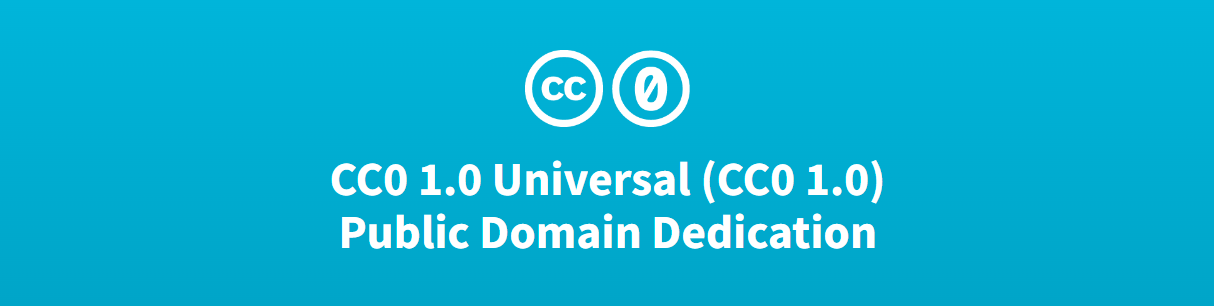